In [1]:
%load_ext autoreload
%autoreload 2

# needed for set_determinism
%set_env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


## Setup

In [2]:
from collections.abc import Callable
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from datasets import Dataset, load_dataset
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
from typing import Optional, Tuple
from jaxtyping import Float
from abc import ABC, abstractmethod
from dataclasses import dataclass
from random import choice, shuffle
from typing import final, cast
import torch.nn.functional as F
import random
import gc

In [3]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_pert, logprobs_ref, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")


def get_random_activations(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos, n_samples
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompts = torch.cat(
        [generate_prompt(dataset, n_ctx=n_ctx) for _ in range(n_samples)]
    )
    _, cache = model.run_with_cache(rand_prompts)
    return cache[layer][:, pos, :].to("cpu").detach()

In [4]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [5]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=928,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [6]:
set_seed(cfg.seed)

In [7]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [8]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [140]:
saes, _ = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
# sparsity = sparsities[cfg.perturbation_layer].cpu()

sae.eval()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Replication

In [10]:
def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [300]:
# generate random prompt
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_prompt_text = model.tokenizer.batch_decode(base_prompt)
print(base_prompt_text)

base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    base_prompt.shape[1],
)

[' State (IS) and its brutalities have wrought']


In [301]:
def run_with_perturbation(base_ref, perturbed_acts):
    # Run the model with the perturbed activation
    def hook(act, hook):
        act[:, -1, :] = perturbed_acts

    prompts = torch.cat([base_ref.prompt for _ in range(perturbed_acts.shape[0])])

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(prompts)

    return logits_pert


def ablate_features(base_ref, sae, feature_ids_to_ablate):
    # Get the base activation from the residual stream
    base_acts = base_ref.act.squeeze()

    # Encode the activation into SAE feature space
    feature_acts = sae.encode(base_acts)

    # Ablate the specified feature
    feature_acts[np.array(feature_ids_to_ablate)] = 0

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    perturbed_act_scaled = perturbed_act * (base_acts.norm() / perturbed_act.norm())
    logits_pert = run_with_perturbation(base_ref, perturbed_act_scaled.unsqueeze(0))

    return logits_pert, perturbed_act_scaled, feature_acts


def perturb_activation(source, target, num_steps=100):
    perturbed_activations = []
    for i in range(num_steps):
        alpha = 1 - (i / (num_steps - 1))  # This goes from 1 to 0
        current = source * alpha + target * (1 - alpha)
        perturbed_activations.append(current)

    return torch.stack(perturbed_activations, dim=0)

In [302]:
# Get base logits
base_acts = base_ref.act.squeeze()
logits_base, _ = model.run_with_cache(base_ref.prompt)
logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

feature_acts = sae.encode(base_acts)
active_feature_ids = (feature_acts > 0.0).nonzero().squeeze().tolist()

In [303]:
all_feature_perturbations = []
all_feature_kl_divs = []
all_feature_cos_sim_to_base = []
all_features_target_feature_acts = []

for feature_id in active_feature_ids:
    leftover_feature_ids = [f_id for f_id in active_feature_ids if f_id != feature_id]
    final_logits_pert, perturbed_acts, abl_feature_acts = ablate_features(
        base_ref, sae, leftover_feature_ids
    )
    target = perturbed_acts - base_acts

    inv_abl_feature_acts = sae.encode(sae.decode(abl_feature_acts))

    num_active = torch.sum(torch.abs(abl_feature_acts) > 0).item()
    num_active_inv = torch.sum(torch.abs(inv_abl_feature_acts) > 0).item()

    if num_active_inv == 0 or abs(num_active - num_active_inv) > 3:
        continue

    print(num_active, num_active_inv)

    cos_sim = cosine_similarity(perturbed_acts, base_acts)
    perturbed_activations = perturb_activation(base_acts, target, cfg.n_steps)

    # Verify that we start at source and end at target
    assert torch.allclose(
        perturbed_activations[0], base_acts, atol=1e-5
    ), "Doesn't start at source"
    assert torch.allclose(
        perturbed_activations[-1], target, atol=1e-5
    ), "Doesn't end at target"

    logits_pert = run_with_perturbation(base_ref, perturbed_activations)
    logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
    kl_divs = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="none"
    ).sum(dim=-1)

    all_feature_perturbations.append(perturbed_activations)
    all_feature_kl_divs.append(kl_divs.detach().cpu())
    all_features_target_feature_acts.append(sae.encode(target))
    all_feature_cos_sim_to_base.append(cos_sim)

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


In [304]:
k = min(10, len(all_feature_cos_sim_to_base))
top_cos_sims, top_idxs = torch.topk(torch.tensor(all_feature_cos_sim_to_base), k)
top_feature_kl_divs = torch.stack(all_feature_kl_divs, dim=0)[top_idxs]
top_active_feature_ids = np.array(active_feature_ids)[top_idxs]

In [305]:
# Generate random other activations
n_samples = 10
random_other_acts = get_random_activations(
    base_ref.model,
    dataset,
    base_ref.n_ctx,
    base_ref.perturbation_layer,
    base_ref.perturbation_pos,
    n_samples=n_samples,
)

random_other_perturbations = []
random_other_kl_divs = []

for target in random_other_acts.squeeze(1):
    perturbed_activations = perturb_activation(base_acts, target, cfg.n_steps)

    # Verify that we start at source and end at target
    assert torch.allclose(
        perturbed_activations[0], base_acts, atol=1e-5
    ), "Doesn't start at source"
    assert torch.allclose(
        perturbed_activations[-1], target, atol=1e-5
    ), "Doesn't end at target"

    logits_pert = run_with_perturbation(base_ref, perturbed_activations)
    logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
    kl_divs = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="none"
    ).sum(dim=-1)

    random_other_perturbations.append(perturbed_activations)
    random_other_kl_divs.append(kl_divs.detach().cpu().numpy())

In [306]:
random_acts = torch.stack([torch.rand_like(base_acts) for _ in range(n_samples)], dim=0)

random_perturbations = []
random_kl_divs = []

for target in random_acts:
    perturbed_activations = perturb_activation(base_acts, target, cfg.n_steps)

    # Verify that we start at source and end at target
    assert torch.allclose(
        perturbed_activations[0], base_acts, atol=1e-5
    ), "Doesn't start at source"
    assert torch.allclose(
        perturbed_activations[-1], target, atol=1e-5
    ), "Doesn't end at target"

    logits_pert = run_with_perturbation(base_ref, perturbed_activations)
    logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
    kl_divs = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="none"
    ).sum(dim=-1)

    random_perturbations.append(perturbed_activations)
    random_kl_divs.append(kl_divs.detach().cpu().numpy())

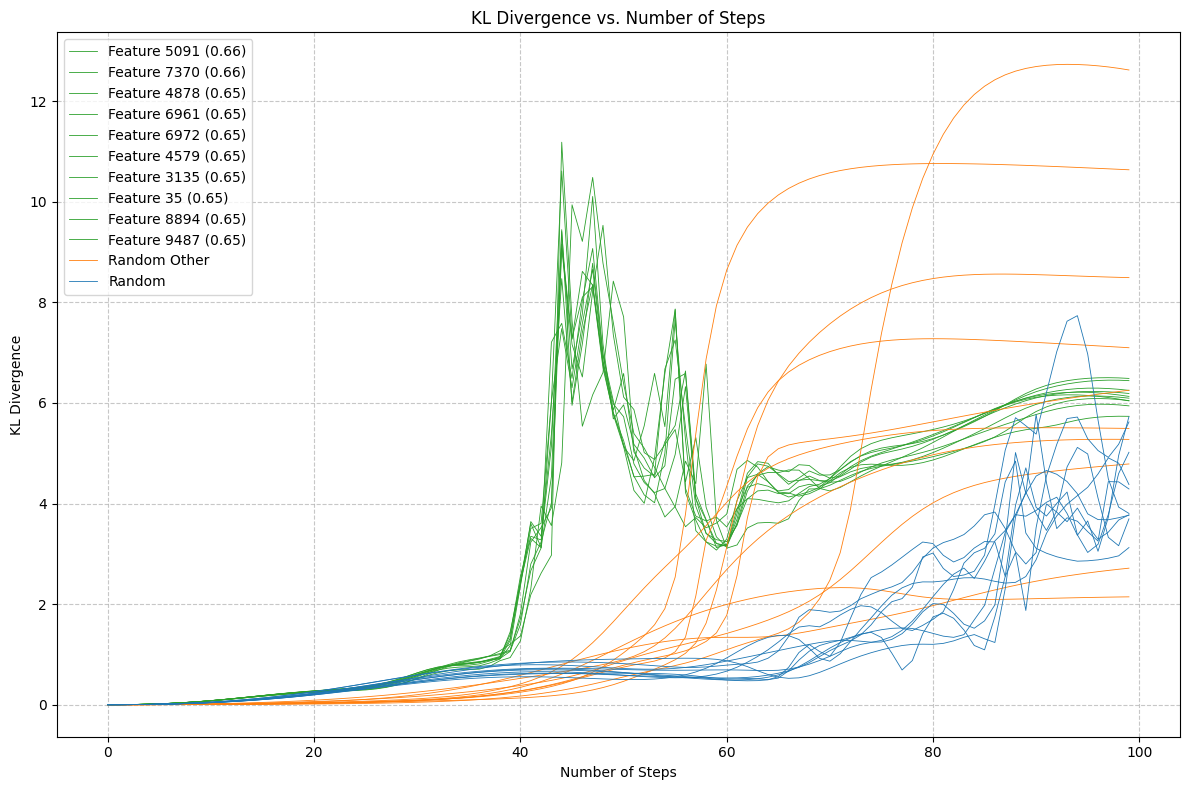

In [307]:
# Create the plot
plt.figure(figsize=(12, 8))

# Plot top features KL divergences
for i in range(len(top_feature_kl_divs)):
    label = f"Feature {top_active_feature_ids[i]} ({round(top_cos_sims[i].item(), 2)})"
    plt.plot(
        range(cfg.n_steps),
        top_feature_kl_divs[i],
        label=label,
        linewidth=0.6,
        color="tab:green",
    )

for i, kl_divs in enumerate(random_other_kl_divs):
    label = "Random Other" if i == 0 else None
    plt.plot(
        range(cfg.n_steps), kl_divs, label=label, linewidth=0.6, color="tab:orange"
    )

for i, kl_divs in enumerate(random_kl_divs):
    label = "Random" if i == 0 else None
    plt.plot(range(cfg.n_steps), kl_divs, label=label, linewidth=0.6, color="tab:blue")


# Customize the plot
plt.xlabel("Number of Steps")
plt.ylabel("KL Divergence")
plt.title("KL Divergence vs. Number of Steps")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

# Show the plot
plt.show()